### Further wrangle with the features 

In [399]:
import time
import datetime
import copy
import numpy as np
import math

import pandas as pd
import json
from bson.json_util import dumps
from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from tqdm import tqdm

In [41]:
pf=ParquetFile('full_1st_setoffeat_events4ml2.parq')

In [42]:
udf=pf.to_pandas()

In [43]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40703 entries, 11049447 to 9968570
Data columns (total 24 columns):
category                 40703 non-null int64
past                     40703 non-null int32
votes                    40703 non-null int64
is_eventbrite            40703 non-null int32
is_free                  40703 non-null int32
doors                    40703 non-null int32
sold_out                 40703 non-null int32
venue.id                 40703 non-null int64
venue.popularity         40703 non-null float64
venue.zip                40703 non-null int64
ticket_allages           40703 non-null int32
ticket_price_low         40703 non-null float64
ticket_price_max         40703 non-null float64
min_age                  40703 non-null int32
artist.popularity.sum    40703 non-null float64
artist.popularity.avg    40703 non-null float64
artist.popularity.max    40703 non-null float64
dow                      40703 non-null int64
doy                      40703 non-null in

In [45]:
# plot pair plots
import seaborn as sns
sns.set(style="ticks", color_codes=True)

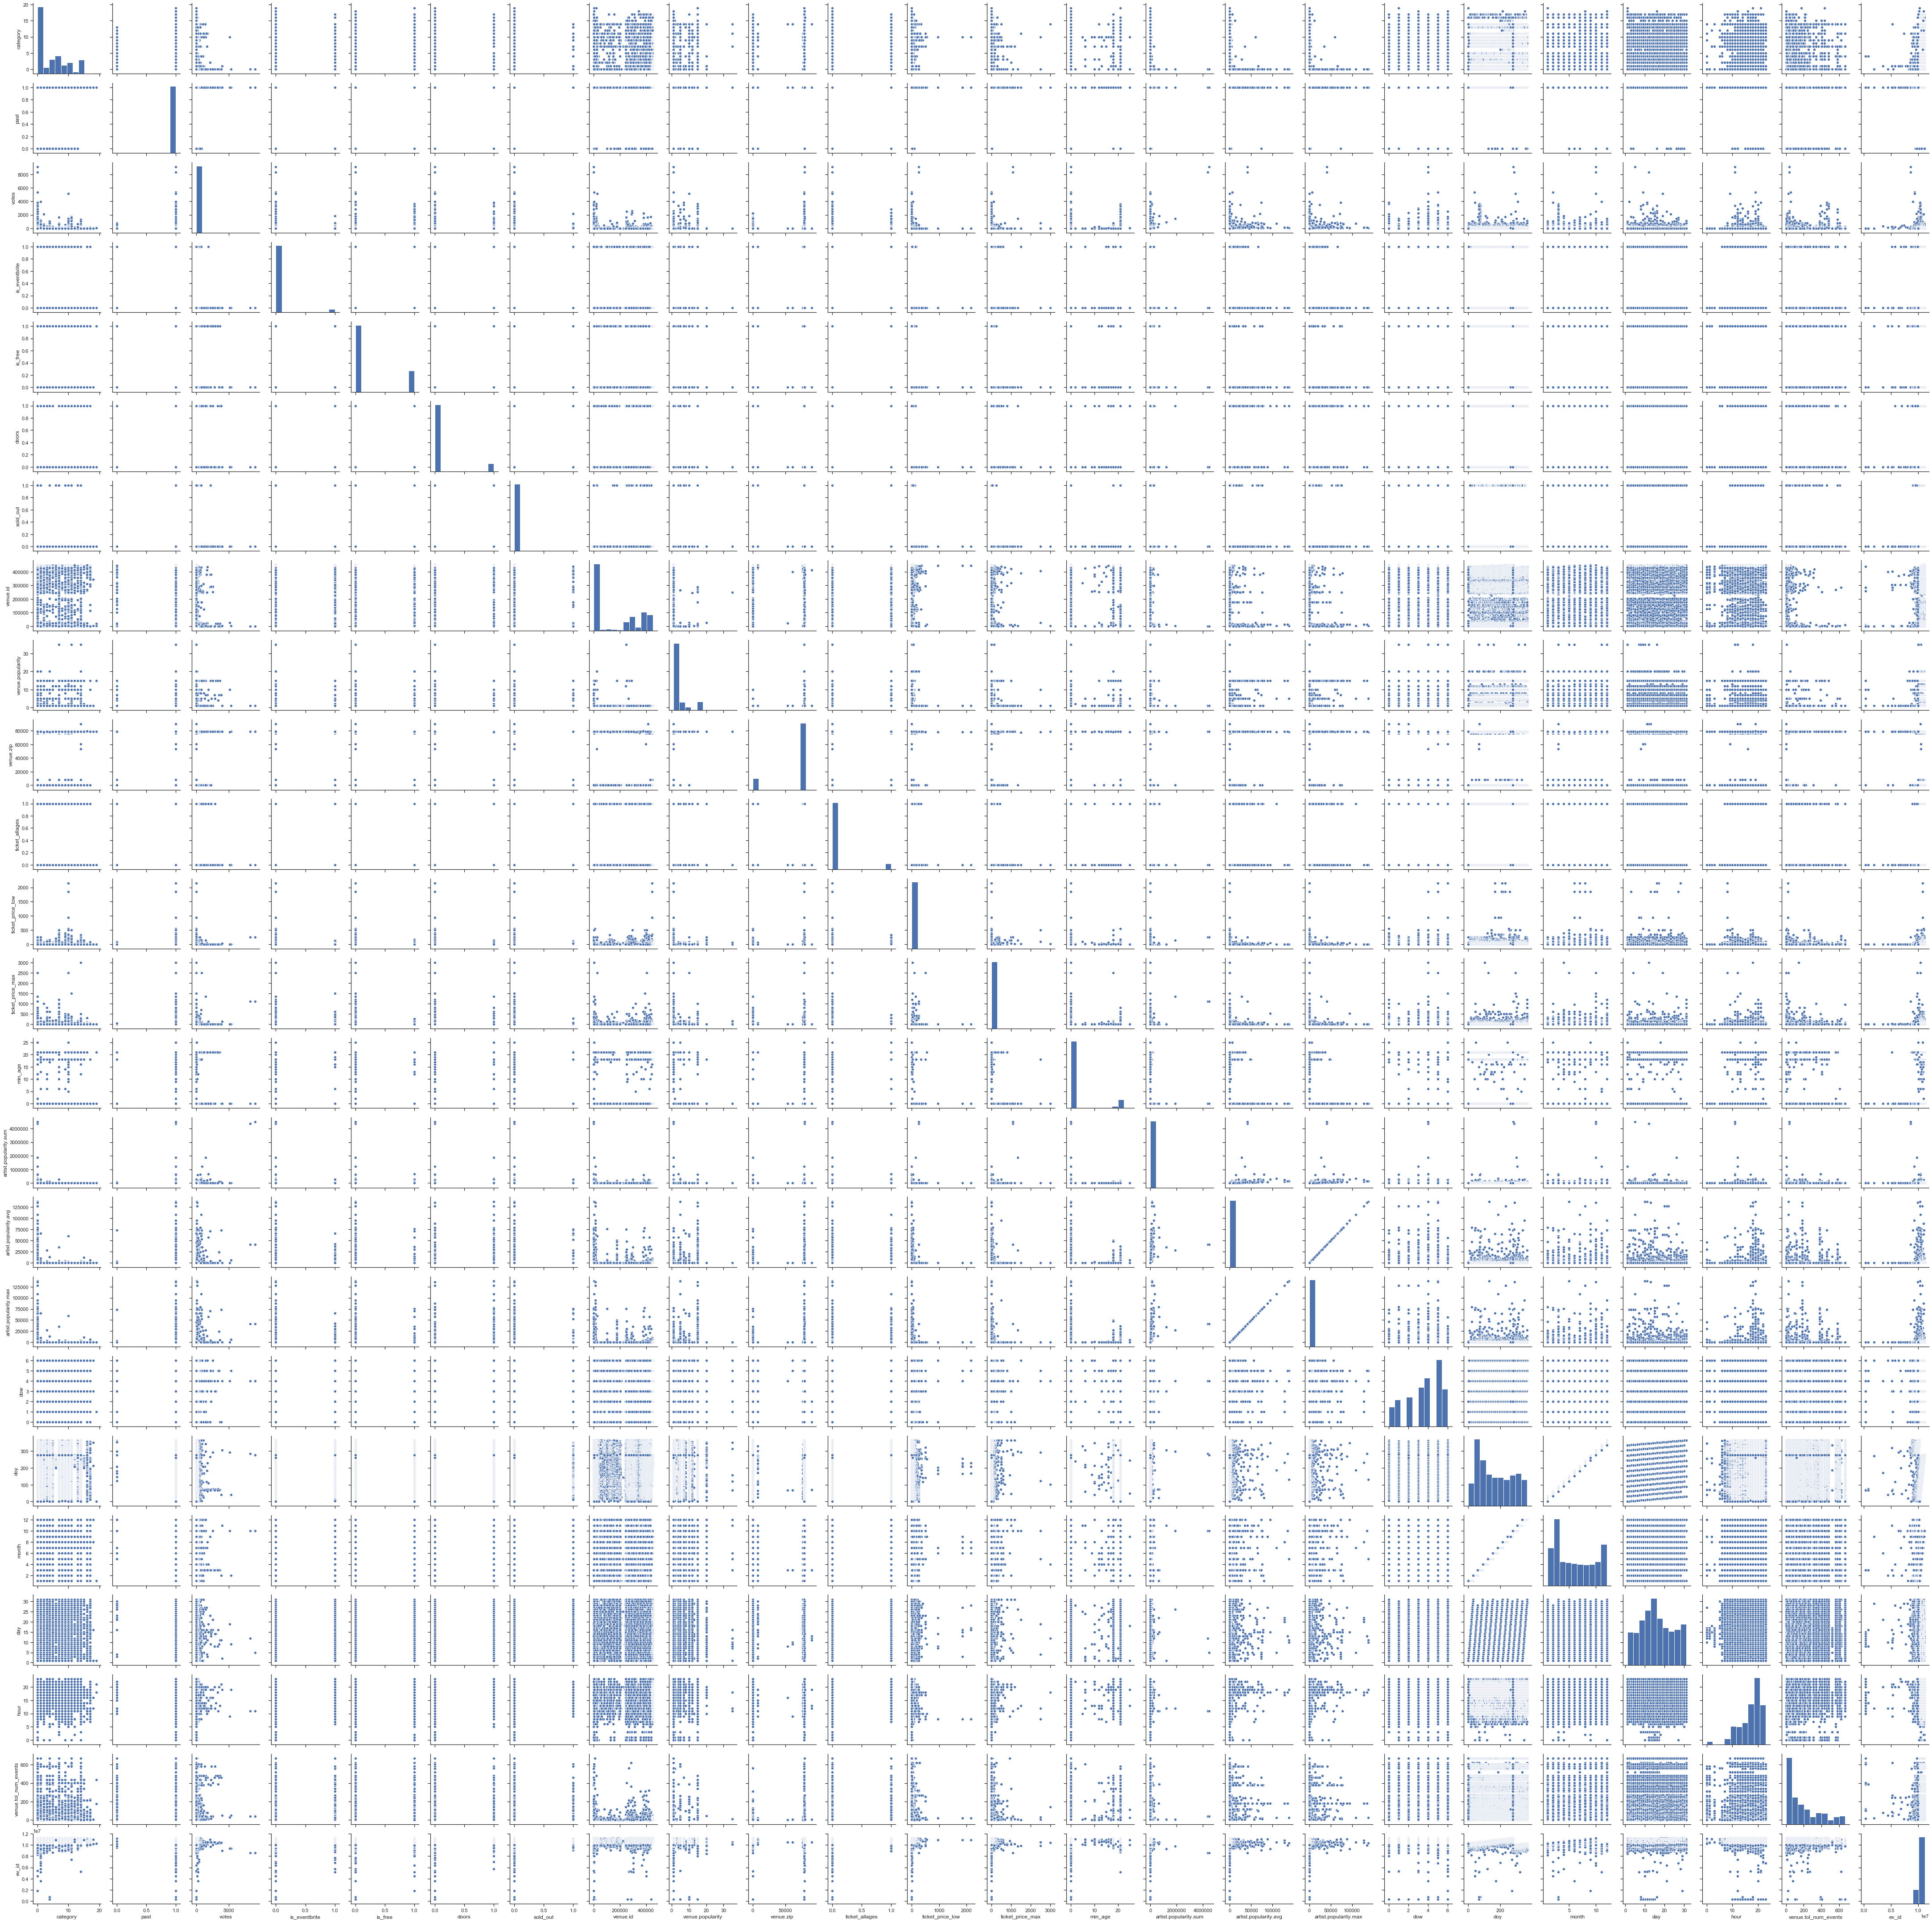

In [46]:
g = sns.pairplot(udf)

In [50]:
g.savefig("featurepairplot.png")

#### Parse the information of event address

In [306]:
## get the addresses
# get the mileage
#df2=pd.read_csv('fullevents_proc_tickets_art.csv')
df2.drop_duplicates(subset='id',inplace=True)

KeyError: Index(['id'], dtype='object')

In [331]:
pf=ParquetFile('do512_10-3-2019-10-3-2018.parquet')
df3=pf.to_pandas()

In [332]:
len(df3)

41865

In [333]:
df3=df3[['id','venue.latitude','venue.longitude']]

In [334]:
df3.drop_duplicates(subset='id',inplace=True)

In [335]:
len(df3)

40703

In [336]:
df3=df3[mask]

In [337]:
len(df3)

38186

In [62]:
df2=df2[['venue.address', 'venue.city', 'venue.state', 'venue.zip']]

In [112]:
## fix all kinds of the 'austin' back to 'Austin'
rep=['AUSTIN','Ausitn','Austin ','AUSTIN ','Austin TX','78701','Austin,','Austin, ','Austin, TX','austin',' Austin','Austi']
df2.loc[df2['venue.city'].isin(rep),'venue.city']='Austin'

In [118]:
# include only specific cities/counties
incities=['Austin','Round Rock','Cedar Park','Pflugerville','Leander','Spicewood','West Lake Hills','Westlake Hills',' Round Rock',' Round Rock','Leander ','Bee cave','Bee Cave']

In [126]:
# fix some more city names
rep2=[' Round Rock']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Round Rock'
rep2=['Leander ']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Leander'
rep2=['Bee cave']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='Bee Cave'
rep2=['Westlake Hills']
df2.loc[df2['venue.city'].isin(rep2),'venue.city']='West Lake Hills'

In [127]:
df2.loc[df2['venue.city'].isin(incities)]['venue.city'].value_counts()

Austin             37370
Round Rock           293
Cedar Park           230
Pflugerville         139
Bee Cave              60
Leander               42
Spicewood             38
West Lake Hills       14
Name: venue.city, dtype: int64

In [134]:
# build a mask based on cities to exclude non-greater-Austin events
mask=df2['venue.city'].isin(incities)
# first mask the original df for such events
udf=udf[mask.values]

In [136]:
address= df2[mask.values]

In [138]:
print("after masking:",len(udf),len(address))

after masking: 38186 38186


In [413]:
# save out the udf
write('full_2nd_events4ml_110419.parq',udf)

Text(0, 0.5, 'event counts')

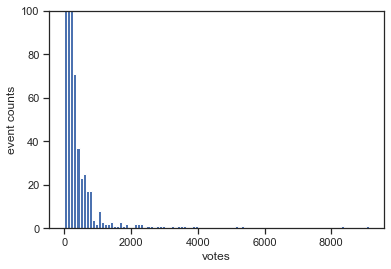

In [388]:
# plot the votes distribution after cleanup of cities
# plot votes distribution for all data
n_bins = 100
x=udf.votes.values
# subset votes to those not 1
xx = [c for c in x if c>0]
fig = plt.hist(xx,bins=n_bins)
plt.ylim([0,100])
plt.xlabel('votes')
plt.ylabel('event counts')
#plt.xlim([1000,9000])

In [155]:
# get a sense of the votes
print("votes over 50:",sum(x>50)/len(x)*100,"%")
print("votes over 100:",sum(x>100)/len(x)*100,"%")
print("votes over 500:",sum(x>500)/len(x)*100,"%")
print("minimum of votes:",min(x),"total number of minimums:",sum(x==0),"accounts for:",sum(x==0)/len(x)*100,"%")
print("votes over 1500:",sum(x>1500),sum(x>1500)/len(x)*100,"%")

votes over 50: 4.965170481328236 %
votes over 100: 2.846592992196093 %
votes over 500: 0.32734510029853875 %
minimum of votes: 0 total number of minimums: 7447 accounts for: 19.501911695385743 %
votes over 1500: 28 0.07332530246687267 %


#### It's a skewed distribution, and popular events are rare events

In [389]:
# prepare to add the feature of 3 mileages
# get a mileages from MapQuest api
## Add Mapquest api route mileage
import requests
#MQ_apikey='5H8c4huF1bsJGyCH36v0ZYniRur5FxrV'
MQ_apikey='ZmSVveGqFO7vGWmEYXBfhftFKmGHb4KT'
MQ_URL='http://www.mapquestapi.com/directions/v2/route?key='
MQ_hd= MQ_URL+MQ_apikey+'&'
MQ_start='from='
MQ_end='&to='
d_south='2300+West+Ben+White+Boulevard,+Austin+Texas,+78704'
d_mid='11801+Domain+Blvd.,+Austin,+Texas,+78758'
d_dwt='600+Congress+Avenue,+Austin,+Texas,+78701'

In [390]:
MQ_hd

'http://www.mapquestapi.com/directions/v2/route?key=ZmSVveGqFO7vGWmEYXBfhftFKmGHb4KT&'

In [202]:
# cleanup the address df for the address text
rep2=['78', 'TV', 'Te', 'Tx', 'te', 'tx']
address.loc[address['venue.state'].isin(rep2),'venue.state']='TX'
address['venue.state']=address['venue.state'].fillna('')

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [203]:
vadd=address['venue.address'].values
vcity=address['venue.city'].values
vstate=address['venue.state'].values
vzip=address['venue.zip'].values
# replace none with blank
#[x for x in vstate if ~np.isnan(x)]

In [269]:
# cleanup the address because mapquest api not behaving well with '#104' type of the content
vadd=[str(x).split('#')[0] for x in vadd]

In [219]:
# cleanup the zipcodes
vzip=[str(x).split(' ')[0] for x in vzip]
vzip=['' if x=='Austin' else x for x in vzip]
vzip=['' if x=='nan' else x for x in vzip]
vzip=['' if len(x)<5 else x for x in vzip]

In [228]:
i=114
evtadd = '+'.join(vadd[i].split())+'+'+str(vcity[i])+'+'+str(vstate[i])+'+'+str(vzip[i])
req=MQ_hd+MQ_start+evtadd+MQ_end+d_mid

In [231]:
# test the request
response=requests.get(req)

In [294]:
# get the mileage

errors=[]
miles_south=[]
miles_mid=[]
miles_dowt=[]
for i in range(len(udf)-675):
    # parse the address and construct the string
    evtadd = '+'.join(vadd[i].split())+'+'+str(vcity[i])+'+'+str(vstate[i])+'+'+str(vzip[i])
    #to Domain
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_mid
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_mid+=[response.json()['route']['distance']]
    else:
        miles_mid+=[None]
        errors+=[i]
    #to downtown
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_dwt
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_dowt+=[response.json()['route']['distance']] 
    else:
        miles_dowt+=[None]
    #to south
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_south
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_south+=[response.json()['route']['distance']]
    else:
        miles_south+=[None]
        

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [345]:
# saveout quested
south=miles_south
mid=miles_mid
downtown=miles_dowt
fronterrors=errors

In [323]:
i

675

In [343]:
# take the rest of the lat-long
vlat=df3['venue.latitude'].values
vlon=df3['venue.longitude'].values

In [344]:
vlat=vlat[i+1:]
vlon=vlon[i+1:]

In [296]:
req

'http://www.mapquestapi.com/directions/v2/route?key=5H8c4huF1bsJGyCH36v0ZYniRur5FxrV&from=10006+Manchaca+Road+Austin+TX+78748&to=11801+Domain+Blvd.,+Austin,+Texas,+78758'

In [346]:
evtadd = str(vlat[i])+','+str(vlon[i])
#to Domain
req=MQ_hd+MQ_start+evtadd+MQ_end+d_mid
print(req)

http://www.mapquestapi.com/directions/v2/route?key=agAWZu309AlgXEqjhiSOerWOybcrLw8X&from=30.2634656,-97.6959036&to=11801+Domain+Blvd.,+Austin,+Texas,+78758


In [353]:
errors=[]
miles_south=[]
miles_mid=[]
miles_dowt=[]
for i in tqdm(range(len(udf)-675)):
    # parse the address and construct the string
    evtadd = str(vlat[i])+','+str(vlon[i])
    #to Domain
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_mid
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_mid+=[response.json()['route']['distance']]
    else:
        miles_mid+=[None]
        errors+=[i]
    #to downtown
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_dwt
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_dowt+=[response.json()['route']['distance']] 
    else:
        miles_dowt+=[None]
    #to south
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_south
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_south+=[response.json()['route']['distance']]
    else:
        miles_south+=[None]
        

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [362]:
# saveout quested
south+=miles_south
mid+=miles_mid
downtown+=miles_dowt

In [407]:
print(len(downtown),len(miles_mid),len(miles_dowt),len(miles_south))

2343 1669 1669 1668


In [393]:
vlat=vlat[i+1:]
vlon=vlon[i+1:]

In [405]:
errors=[]
miles_south=[]
miles_mid=[]
miles_dowt=[]
for i in tqdm(range(len(udf)-2343)):
    # parse the address and construct the string
    evtadd = str(vlat[i])+','+str(vlon[i])
    #to Domain
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_mid
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_mid+=[response.json()['route']['distance']]
    else:
        miles_mid+=[None]
        errors+=[i]
    #to downtown
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_dwt
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_dowt+=[response.json()['route']['distance']] 
    else:
        miles_dowt+=[None]
    #to south
    req=MQ_hd+MQ_start+evtadd+MQ_end+d_south
    response=requests.get(req)
    if 'distance' in response.json()['route'].keys():
        miles_south+=[response.json()['route']['distance']]
    else:
        miles_south+=[None]
        

  5%|█▊                                      | 1668/35843 [47:01<13:15:28,  1.40s/it]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [406]:
i

1668

In [396]:
len(udf)-len(vlat)

2344

In [414]:
len(mid)

2343

In [415]:
#saveout to backup
with open('milesmid.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % dist for dist in mid)

In [416]:
with open('milessouth.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % dist for dist in south)

In [418]:
with open('milesdowntown.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % dist for dist in downtown)

In [408]:
req2='http://www.mapquestapi.com/directions/v2/route?key=ZmSVveGqFO7vGWmEYXBfhftFKmGHb4KT&from=470+Deloss+Dodds+Way+Austin+TX+78712&to=11801+Domain+Blvd.,+Austin,+Texas,+78758'

In [409]:
response=requests.get(req2)

In [411]:
response.status_code

403

In [352]:
# testing the esri api


2025